## Figure pool and profiles

In [12]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import matplotlib.lines as mlines
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [13]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [23]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def getMeanProfile(ptracers_file, mask, trac, xind, yind, zslice, tslice):
    
    with Dataset(ptracers_file, 'r') as nbl:
         tr = np.ma.masked_array(np.nanmean(nbl.variables[trac][tslice,zslice,yind,xind],axis=0),
                                 mask = mask[zslice,yind,xind])
       
    return (tr)

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=0.2, cmax=1.8):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
                                                          1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8],
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,1.0],colors='k')
    plt.clabel(cs, fmt='%1.1f')
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotBdy(ax,ConcFilt,X,Y,xslice,yslice,color):
    
    BAC = ConcFilt[yslice,xslice]
    
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[1.0],colors=color)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)   
                       
    ax.set_aspect(1)
    return(cs)

def PlotPoolsTr(ax1,tslice, key, ptr_fileA, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,sbind,
                sbdepthA=-150):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.delta_r, cmin=0.2, cmax=1.8)

    ax1.set_facecolor("darkgrey")
    ax1.set_aspect(1)
    return(ax1, mesh1)

def PlotPoolBoundary(ax1, tslice, key, ptr_fileA, 
                     xslice_pl, yslice_pl, nz,
                     hFacA, rAA, DepthA, XA, YA,sbind,color,
                     sbdepthA=-150):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotBdy(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                        xslice_pl,yslice_pl,color)

    ax1.set_aspect(1)
    return(ax1)

def plot_pool_profiles(ax0,ax1,ax2,ax3,ptr_file,maskC, ptr_fileNoC,maskCNoC, key, units,
                       zslice,ZA, yindA, xindA, sbind, max_dC=1):
    
    pal1 = sns.color_palette('Greens', 10)
    
    for ii,ax,st in zip(range(4),[ax0,ax1,ax2,ax3],['S1','S2','S3','S4']):
        ax.axhline(-20, color='0.8')
        ax.set_xlabel(r'$\Delta C$ / %s' %units, labelpad=0)
        ax.set_ylim(ZA[sbind],0)
        ax.set_xlim(-0.1, max_dC)
        ax.text(0.01,0.92,st,transform=ax.transAxes) 
    for ii,ax in zip(range(4),[ax0,ax1,ax2,ax3]):
        for tt in range(0,19,4):
            tr = getProfile(ptr_file, maskC, key, xindA[ii], yindA[ii], zslice, tt)
            trNoC = getProfile(ptr_fileNoC,maskCNoC, key, xindA[ii], yindA[ii], zslice, tt)
            ax.plot(tr-trNoC, ZA[zslice],color=pal1[int(tt/2)], label='day %d' %(tt/2))
            ax.tick_params(axis='x', pad=1)
            ax.tick_params(axis='y', pad=1)   
           
            
    ax0.set_ylabel('Depth / m', labelpad=0)
    
    return(ax3) 
 
def plot_profiles_advPh(ax0,ax1,ax2,ax3,ptr_file,maskC, ptr_fileNoC, maskCNoC,key,color,Csb,
                        zslice,tslice, ZA, yindA, xindA, sbind, max_dC=100, min_dC=-20):
    
    for ii,ax,st in zip(range(4),[ax0,ax1,ax2,ax3],['S1','S2','S3','S4']):
        ax.axhline(-20, color='0.8')
        ax.set_xlabel(r'$\Delta C/C_s$ $\%$', labelpad=0)
        ax.set_ylim(ZA[sbind],0)
        ax.set_xlim(min_dC, max_dC)
        ax.text(0.01,0.92,st,transform=ax.transAxes) 
    for ii,ax in zip(range(4),[ax0,ax1,ax2,ax3]):
        tr = getMeanProfile(ptr_file, maskC, key, xindA[ii], yindA[ii], zslice, tslice)
        trNoC = getMeanProfile(ptr_fileNoC,maskCNoC, key, xindA[ii], yindA[ii], zslice, tslice)
        ax.plot(100*(tr-trNoC)/Csb, ZA[zslice],color=color, label='key')
        ax.tick_params(axis='x', pad=1)
        ax.tick_params(axis='y', pad=1)   
         
    ax0.set_ylabel('Depth / m', labelpad=0)
    
    return(ax3) 
 

In [15]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#44AA99','#117733','#999933','#AA4499']
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']

In [16]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

In [17]:
nz = 104
nt = 19
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    DepthBNoC = nbl.variables['Depth'][:]
    rABNoC = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
    DepthANoC = nbl.variables['Depth'][:]
    rAANoC = nbl.variables['rA'][:]
    
with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
sb_depthA = ZA[sb_Ast]
sb_depthB = ZB[sb_Bar]


In [18]:
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['($\mu$M)m$^{3}$s$^{-1}$','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']
factors = [1,1,1,1E-3,1]
colours = ['#332288','#44AA99','#117733','#999933','#AA4499','#DDCC77','#CC6677','#882255', 'brown', 'tan']

In [19]:
sb_conc_A = np.empty(len(labels_tra))
sb_conc_B = np.empty(len(labels_tra))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            sb_array[ii] = tr_profile[sb_ind]

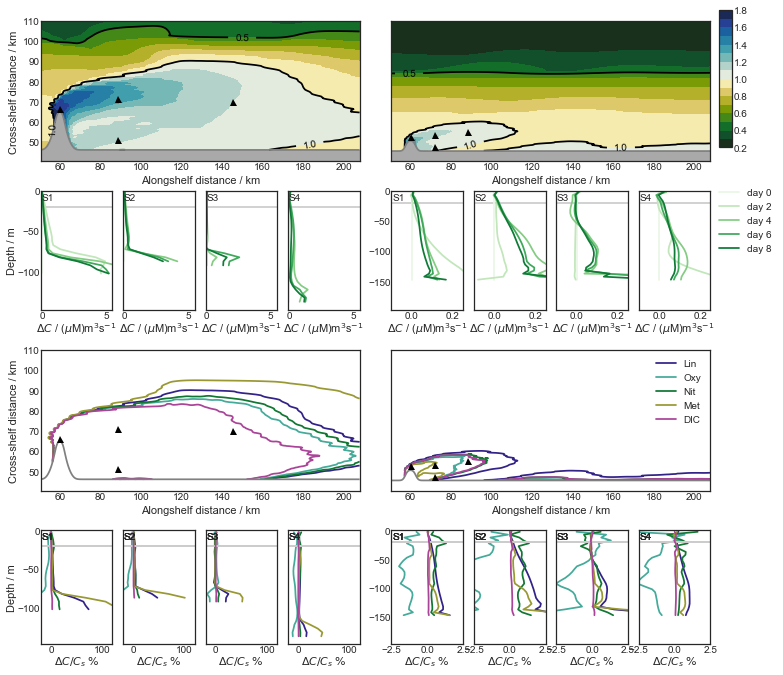

In [24]:
sns.set_style('white')
fig=plt.figure(figsize=(12,12))

gs = gspec.GridSpec(2, 2, hspace=0.05,wspace=0.1)

gs0 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,0],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs01 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[1],wspace=0.15,width_ratios=[1,1,1,1])

gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,1],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs11 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs1[1],wspace=0.15,width_ratios=[1,1,1,1])

gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0.1,wspace=0.15,height_ratios=[1,0.6])
gs21 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs2[1],wspace=0.15,width_ratios=[1,1,1,1])

gs3 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,1],hspace=0.1,wspace=0.15,height_ratios=[1,0.6])
gs31 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs3[1],wspace=0.15,width_ratios=[1,1,1,1])

ax0 = plt.subplot(gs0[0])
ax1 = plt.subplot(gs01[0])
ax2 = plt.subplot(gs01[1])
ax3 = plt.subplot(gs01[2])
ax3b = plt.subplot(gs01[3])
 
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs11[0])
ax6 = plt.subplot(gs11[1])
ax7 = plt.subplot(gs11[2])
ax7b = plt.subplot(gs11[3])

ax8 = plt.subplot(gs2[0])
ax9 = plt.subplot(gs21[0])
ax10 = plt.subplot(gs21[1])
ax11= plt.subplot(gs21[2])
ax11b = plt.subplot(gs21[3])

ax12 = plt.subplot(gs3[0])
ax13 = plt.subplot(gs31[0])
ax14 = plt.subplot(gs31[1])
ax15= plt.subplot(gs31[2])
ax15b = plt.subplot(gs31[3])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)
tslice = slice(8,nt)
key = 'Tr01'

# Bottom concetration linear profile (mean during adv. phase)
ax0, mesh0 = PlotPoolsTr(ax0, tslice, key, ptr_fileA, 
                  xslice_pl, yslice_pl, nz,
                  hFacA, rAA, DepthA, XA, YA,sb_Ast,
                  sbdepthA=sb_depthA)
ax0.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],[-sb_depthA], colors='0.5')

ax4, mesh4 = PlotPoolsTr(ax4, tslice, key, ptr_fileB, 
                         xslice_pl, yslice_pl, nz,
                         hFacB, rAB, DepthB, XB, YB,sb_Bar,
                         sbdepthA=sb_depthB)
ax4.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],[-sb_depthB], colors='0.5')
ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km')
ax0.set_xlabel('Alongshelf distance / km')
ax4.set_xlabel('Alongshelf distance / km')

cbar_ax = fig.add_axes([0.91, 0.7, 0.015, 0.159])
cb=fig.colorbar(mesh4, cax=cbar_ax,ticks=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8],format='%1.1f')
cb.ax.yaxis.set_tick_params(pad=2)

# Plot linear tracer profiles
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    
ax0.plot(XA[xindA]/1000, YA[yindA]/1000, '^k', markeredgecolor='0.5')
ax4.plot(XB[xindB]/1000, YB[yindB]/1000, '^k', markeredgecolor='0.5')    

zslice = slice(0,30)
zsliceB = slice(0,50)
unit = units[0]

ax3b = plot_pool_profiles(ax1,ax2,ax3,ax3b,ptr_fileA,maskCA, ptr_fileANoC,maskCANoC,key,
                          unit, zslice,
                          ZA, yindA, xindA,sb_Ast, max_dC = 5.5)
ax7b = plot_pool_profiles(ax5,ax6,ax7,ax7b,ptr_fileB,maskCB, ptr_fileBNoC,maskCBNoC,key,
                          unit, zslice,
                          ZB, yindB, xindB, sb_Bar, max_dC=0.25)
ax7b.legend(bbox_to_anchor=(1,0.4))
ax5.set_ylabel('')

# Pool boundary all tracers (mean during adv. phase)
proxy = []
for key, color, lab in zip(tracers[:], colours[:], labels_tra[:]):
    ax8 = PlotPoolBoundary(ax8, tslice, key, ptr_fileA, 
                           xslice_pl, yslice_pl, nz,
                           hFacA, rAA, DepthA, XA, YA,sb_Ast,color,
                           sbdepthA=sb_depthA)

    ax12 = PlotPoolBoundary(ax12, tslice, key, ptr_fileB, 
                           xslice_pl, yslice_pl, nz,
                           hFacB, rAB, DepthB, XB, YB,sb_Bar,color,
                           sbdepthA=sb_depthB)
    
    line = mlines.Line2D([], [], color=color, label=lab)
    proxy.append(line)

ax8.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],[-sb_depthA], colors='0.5')
ax12.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],[-sb_depthB], colors='0.5')
ax12.legend(handles=proxy)
ax12.yaxis.set_ticks([])
ax8.set_ylabel('Cross-shelf distance / km')
ax8.set_xlabel('Alongshelf distance / km')
ax12.set_xlabel('Alongshelf distance / km')

ax8.plot(XA[xindA]/1000, YA[yindA]/1000, '^k', markeredgecolor='0.5')
ax12.plot(XB[xindB]/1000, YB[yindB]/1000, '^k', markeredgecolor='0.5')    


# Plot mean anomaly profiles all tracers 

for key, color, lab, Csb in zip(tracers[:], colours[:], labels_tra[:],sb_conc_A[:]):
    ax11b = plot_profiles_advPh(ax9,ax10,ax11,ax11b,ptr_fileA,maskCA, ptr_fileANoC,maskCANoC, key,color, Csb,
                                zslice,tslice, ZA, yindA, xindA, sb_Ast, max_dC=120, min_dC=-20)

for key, color, lab, Csb in zip(tracers[:], colours[:], labels_tra[:],sb_conc_B[:]):
    ax15b = plot_profiles_advPh(ax13,ax14,ax15,ax15b,ptr_fileB,maskCB, ptr_fileBNoC,maskCBNoC, key,color, Csb,
                                zslice,tslice, ZB, yindB, xindB, sb_Bar,max_dC=2.5, min_dC=-2.5)
ax13.set_ylabel('')
# Other aesthetics
for ax in [ax2,ax3,ax3b,ax6,ax7,ax7b,ax10,ax11,ax11b,ax14,ax15,ax15b]: 
      ax.yaxis.set_ticks([])
        

In [ ]:
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    


In [22]:
DepthB[140,250]

86.0263987391645